# CM3070 Final Year Project: Bitcoin Price Forecasting - PART 2

Template 1: Deep Learning on a Public Dataset (Machine Learning)		
Done by Student Number: 190488303

### Reimport data, libraries and packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls drive/MyDrive/bitcoin_data.csv

drive/MyDrive/bitcoin_data.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import plotly.graph_objs as go
import gc

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [4]:
#create a function for conversion for the native timestamps in the csv file

import datetime, pytz

def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

bitcoin_df = pd.read_csv("drive/MyDrive/bitcoin_data.csv", parse_dates = [0], date_parser = dateparse)
bitcoin_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-process data

In [5]:
# using hourly data
bitcoin_df = bitcoin_df.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

# setting timestamp as index
bitcoin_df['Timestamp'] = bitcoin_df['Timestamp'].dt.tz_localize(None)
bitcoin_df = bitcoin_df.set_index('Timestamp')

# using weighted price to represent btc price
bitcoin_df = bitcoin_df[['Weighted_Price']]

# fill null values with previous data
bitcoin_df['Weighted_Price'].fillna(method='ffill', inplace=True)
bitcoin_df.head()

,Weighted_Price
Timestamp,
2011-12-31 07:00:00,4.39
2011-12-31 08:00:00,4.39
2011-12-31 09:00:00,4.39
2011-12-31 10:00:00,4.39
2011-12-31 11:00:00,4.39


In [6]:
# using data from pre-covid era

day_of_split = '1-Nov-2020'
new_df = bitcoin_df.loc[bitcoin_df.index < day_of_split].copy()

print(new_df.shape)

new_df.tail()

(77465, 1)


,Weighted_Price
Timestamp,
2020-10-31 19:00:00,13721.410258
2020-10-31 20:00:00,13790.617058
2020-10-31 21:00:00,13857.773177
2020-10-31 22:00:00,13849.847259
2020-10-31 23:00:00,13876.907219


## Data splitting

In [7]:
# splitting data into training and test sets
day_of_split = '25-Jun-2018'

testing_data = new_df.loc[new_df.index > day_of_split].copy()
training_data = new_df.loc[new_df.index <= day_of_split].copy()

print(testing_data.shape)
print(training_data.shape)

(20639, 1)
(56826, 1)


## Pre-processing

In [9]:
# data preprocessing
set_train_val = training_data.values
set_train_val = np.reshape(set_train_val, (len(set_train_val), 1))

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
set_train_val = mms.fit_transform(set_train_val)
y_train = set_train_val[1: len(set_train_val)]
X_train = set_train_val[0: len(set_train_val)-1]

print(X_train.shape)
print(y_train.shape)

(56825, 1)
(56825, 1)


### 5.4 Linear Regression

5.4.1 Modelling

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

5.4.2 Prediction

In [13]:
# forming predictions

set_test_val = testing_data.values

insert = np.reshape(set_test_val, (len(set_test_val), 1))
insert = mms.transform(insert)
insert = np.reshape(insert, (len(insert), 1))

btc_price_prediction = lr_model.predict(insert)
btc_price_prediction = btc_price_prediction.reshape(1, -1)
btc_price_prediction = mms.inverse_transform(btc_price_prediction)
btc_price_prediction = btc_price_prediction.reshape(-1, 1)

btc_price_prediction

array([[ 6169.48214427],
       [ 6147.95723448],
       [ 6131.03142772],
       ...,
       [13856.57632627],
       [13848.65124721],
       [13875.70834297]])

In [14]:
testing_data['Weighted_Price_Prediction'] = btc_price_prediction
data_all = pd.concat([testing_data, training_data], sort=False)

# store predicted values into common dataframe 
df_last = data_all
df_last = df_last.reset_index()
df_last = df_last.rename(columns = {'Weighted_Price_Prediction': 'LR'})
df_last = df_last[['Timestamp','Weighted_Price','LR']]
df_last.head()

,Timestamp,Weighted_Price,LR
0,2018-06-25 01:00:00,6169.865248,6169.482144
1,2018-06-25 02:00:00,6148.338059,6147.957234
2,2018-06-25 03:00:00,6131.410461,6131.031428
3,2018-06-25 04:00:00,6139.076296,6138.696451
4,2018-06-25 05:00:00,6141.563349,6141.183241


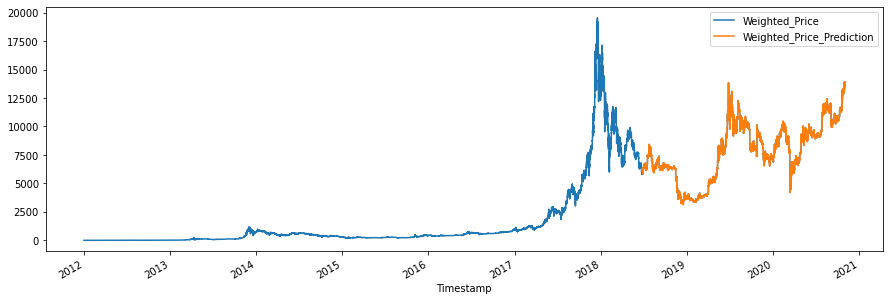

In [15]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

5.4.2 Evaluation metrics (MAE, MSE, RMSE)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_true=testing_data['Weighted_Price'],
                   y_pred=testing_data['Weighted_Price_Prediction'])

print("Mean Accuracy Error:\n")
print(mae)

Mean Accuracy Error:

0.5548375584962348


In [17]:
mse = mean_squared_error(y_true=testing_data['Weighted_Price'],
                   y_pred=testing_data['Weighted_Price_Prediction'])

print("Mean Square Error:\n")
print(mse)

Mean Square Error:

0.3768683943105113


In [18]:
import math
rmse = math.sqrt(mse)

print("Root Mean Square Error:\n")
print(rmse)

Root Mean Square Error:

0.613896077777429


5.4.3 Evaluation metrics (Variance regression score, R2 score)

In [19]:
from sklearn.metrics import explained_variance_score
evr = (explained_variance_score(y_true=testing_data['Weighted_Price'], y_pred=testing_data['Weighted_Price_Prediction']))*100

print("Explained variance regression score:", evr, "%")

Explained variance regression score: 99.99999887962717 %


In [20]:
from sklearn.metrics import r2_score
r2 = (r2_score(y_true=testing_data['Weighted_Price'], y_pred=testing_data['Weighted_Price_Prediction']))*100

print("R2 score:", r2, "%")

R2 score: 99.99999388277877 %


### 5.5 ARIMA model

5.5.1 Modelling

In [22]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
import warnings

In [23]:
#create a function for conversion for the native timestamps in the csv file

import datetime, pytz

def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

bitcoin_df = pd.read_csv("drive/MyDrive/bitcoin_data.csv", parse_dates = [0], date_parser = dateparse)
bitcoin_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# using hourly data
bitcoin_df = bitcoin_df.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()

# setting timestamp as index
bitcoin_df['Timestamp'] = bitcoin_df['Timestamp'].dt.tz_localize(None)
bitcoin_df = bitcoin_df.set_index('Timestamp')

# using weighted price to represent btc price
bitcoin_df = bitcoin_df[['Weighted_Price']]

# fill null values with previous data
bitcoin_df['Weighted_Price'].fillna(method='ffill', inplace=True)
bitcoin_df.head()

,Weighted_Price
Timestamp,
2011-12-31,4.390000
2012-01-31,4.580000
2012-02-29,5.525435
2012-03-31,4.990000
2012-04-30,4.890000


In [26]:
Ps = range(0, 3)
ps = range(0, 3)
Qs = range(0, 2)
qs = range(0, 3)

d=1
D=1

para = product(ps, qs, Ps, Qs)
para_list = list(para)
len(para_list)

# Model Selection
resulting = []
aic_bestest = float("inf")
warnings.filterwarnings('ignore')

for parameters in para_list:
    try:
        arima_model=sm.tsa.statespace.SARIMAX(bitcoin_df.Weighted_Price, order=(parameters[0], d, parameters[1]), 
                    seasonal_order=(parameters[2], D, parameters[3], 12),enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        continue

    aic = arima_model.aic

    if aic < aic_bestest:
        model_best = arima_model
        aic_bestest = aic
        best_param = parameters
    resulting.append([parameters, arima_model.aic])

In [27]:
# finding the best model

result_table = pd.DataFrame(resulting)
result_table.columns = ['parameters', 'aic']
print(model_best.summary())
print(result_table.sort_values(by = 'aic', ascending=True).head())

                                     SARIMAX Results                                      
Dep. Variable:                     Weighted_Price   No. Observations:                  112
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -651.204
Date:                            Mon, 05 Sep 2022   AIC                           1312.407
Time:                                    09:42:28   BIC                           1323.860
Sample:                                12-31-2011   HQIC                          1316.971
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5665      0.110      5.153      0.000       0.351       0.782
ar.L2          0.4074      0.143   

Dickey–Fuller test:: p=0.000000


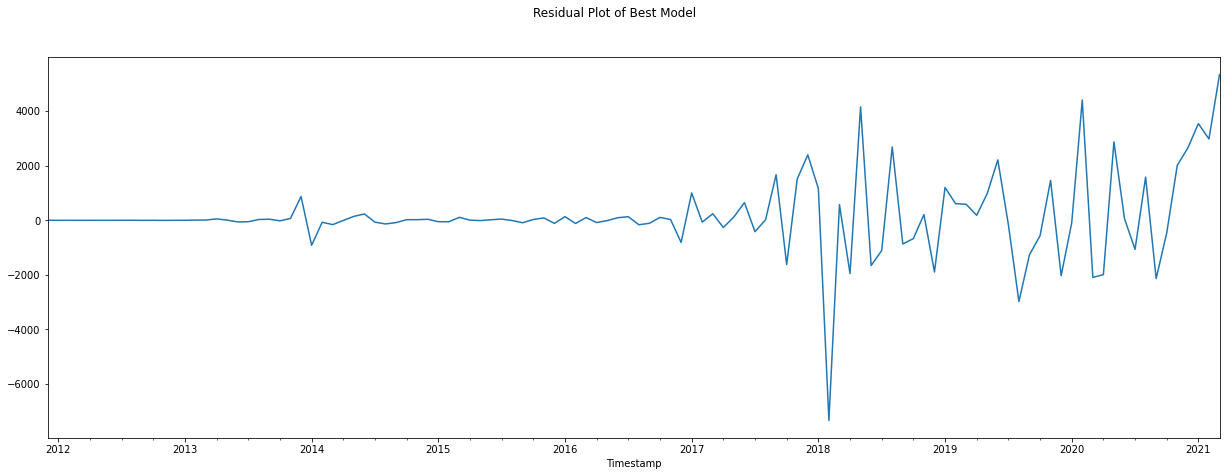

In [28]:
fig = plt.figure(figsize=(21,7))
model_best.resid.plot()
fig.suptitle('Residual Plot of Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(model_best.resid)[1])

5.5.2 Prediction

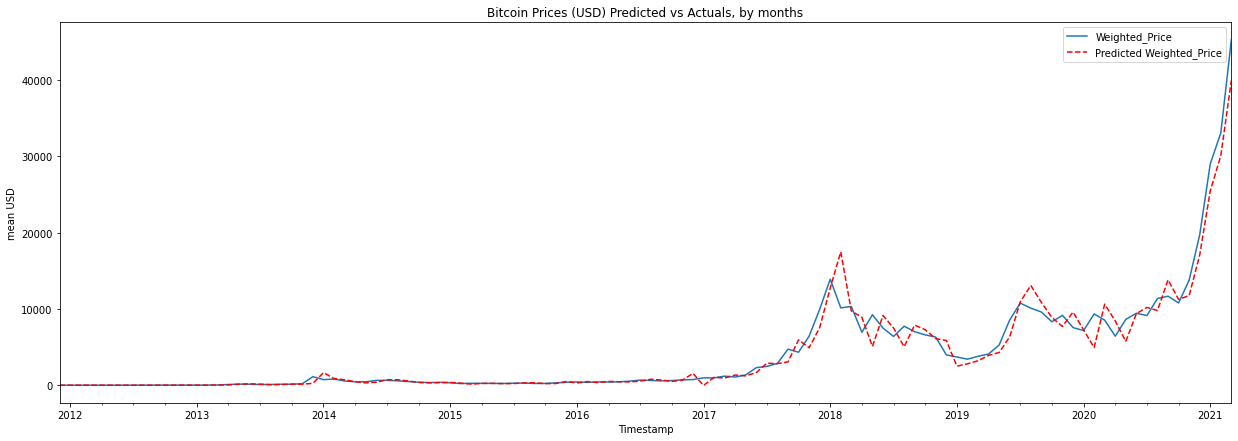

In [29]:
btc_df_month = bitcoin_df[['Weighted_Price']]
future_price = pd.DataFrame()
btc_df_month = pd.concat([btc_df_month, future_price])
btc_df_month['forecast'] = model_best.predict(start=0, end=200)

plt.figure(figsize=(21,7))
btc_df_month.Weighted_Price.plot()
btc_df_month.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')

plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [30]:
# find predicted values

prediction = model_best.predict(start=0, end=111)
prediction = prediction.to_numpy()

bitcoin_df['Weighted_Price_Prediction'] = prediction

In [31]:
final_data = bitcoin_df.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'ARIMA'})
final_data = final_data[['Timestamp','Weighted_Price','ARIMA']]

5.5.3 Evaluation metrics (MAE, MSE, RMSE)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_true=final_data['Weighted_Price'],
                   y_pred=final_data['ARIMA'])

print("Mean Accuracy Error:\n")
print(mae)
print()

Mean Accuracy Error:

780.9481408538622



In [33]:
mse = mean_squared_error(y_true=final_data['Weighted_Price'],
                   y_pred=final_data['ARIMA'])

print("Mean Square Error:\n")
print(mse)

Mean Square Error:

2153527.7231133715


In [34]:
import math
rmse = math.sqrt(mse)

print("Root Mean Square Error:\n")
print(rmse)

Root Mean Square Error:

1467.4902804152985


5.5.3 Evaluation metrics (Variance regression score, R2 score)

In [35]:
from sklearn.metrics import explained_variance_score

evr = (explained_variance_score(y_true=final_data['Weighted_Price'], y_pred=final_data['ARIMA']))*100

print("Explained variance regression score:", evr, "%")

Explained variance regression score: 95.4059050828312 %


In [36]:
from sklearn.metrics import r2_score
r2 = (r2_score(y_true=final_data['Weighted_Price'], y_pred=final_data['ARIMA']))*100

print("R2 score:", r2, "%")

R2 score: 95.36372593970333 %
